In [1]:
import nltk
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import bokeh
import matplotlib.pyplot as plt
import pylab as pl
from ast import literal_eval
import string
import random
import cache_magic
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree
from sklearn.metrics.pairwise import cosine_similarity
import re
from nltk.stem import WordNetLemmatizer

%cache magic is now registered in ipython


In [2]:
DATA_MAG = "/Users/pnguyen/Documents/DaVinci/Data/wine-reviews/winemag-data-130k-v2.csv"

In [3]:
TOKENIZED_DATA_MAG = "/Users/pnguyen/Documents/DaVinci/Data/wine-reviews/winemag-data-130k-v2-tokenized.csv"

In [4]:
df = pd.read_csv(DATA_MAG, index_col=0)
df.shape

(129971, 13)

In [5]:
df = df.drop_duplicates()
df.shape

(119988, 13)

In [6]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119988 entries, 0 to 129970
Data columns (total 13 columns):
country                  119929 non-null object
description              119988 non-null object
designation              85443 non-null object
points                   119988 non-null int64
price                    111593 non-null float64
province                 119929 non-null object
region_1                 100428 non-null object
region_2                 46769 non-null object
taster_name              95071 non-null object
taster_twitter_handle    90542 non-null object
title                    119988 non-null object
variety                  119987 non-null object
winery                   119988 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 12.8+ MB


In [8]:
df.rename(columns={'variety': 'varietal'}, inplace=True)
# gotta use the correct terminology
# yes I'm a bit snobbish why'd you ask?
# sorry not sorry

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b796710>]],
      dtype=object)

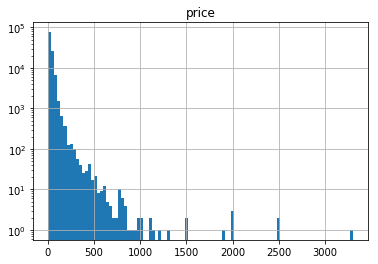

In [9]:
df.hist(column = 'price', bins=100, log=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1a553f28>]],
      dtype=object)

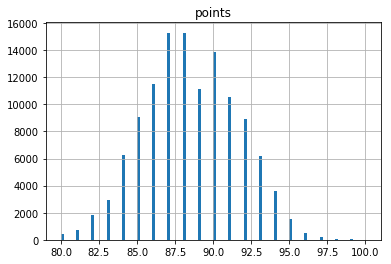

In [10]:
df.hist(column = 'points', bins=100)

In [11]:
df['unique_taster'] = df['taster_name'] + df['taster_twitter_handle'].fillna('__notwitter')

In [12]:
df['unique_taster'].value_counts()

Roger Voss@vossroger                23560
Michael Schachner@wineschach        14046
Kerin O’Keefe@kerinokeefe            9697
Paul Gregutt@paulgwine               8868
Virginie Boone@vboone                8708
Matt Kettmann@mattkettmann           5730
Joe Czerwinski@JoeCz                 4766
Sean P. Sullivan@wawinereport        4461
Anna Lee C. Iijima__notwitter        4017
Jim Gordon@gordone_cellars           3766
Anne Krebiehl MW@AnneInVino          3290
Lauren Buzzeo@laurbuzz               1700
Susan Kostrzewa@suskostrzewa         1023
Mike DeSimone@worldwineguys           461
Jeff Jenssen@worldwineguys            436
Alexander Peartree__notwitter         383
Carrie Dykes__notwitter               129
Fiona Adams@bkfiona                    24
Christina Pickard@winewchristina        6
Name: unique_taster, dtype: int64

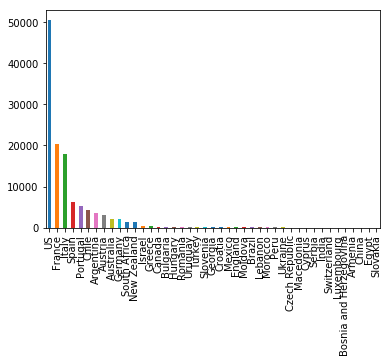

In [13]:
fig, ax = plt.subplots()
df['country'].value_counts().plot(ax=ax, kind='bar')

A few countries makes up for most of the wines

279.48470588235296

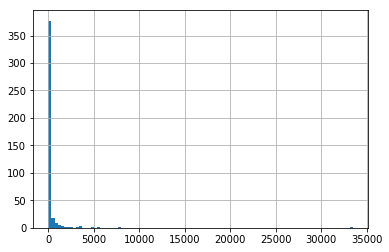

In [14]:
df.groupby(by='province')['title'].nunique().hist(bins=100)
df.groupby(by='province')['title'].nunique().mean() #number of wines per province on average

In [15]:
df['province'].value_counts()[:10]

California          33656
Washington           7965
Bordeaux             5556
Tuscany              5391
Oregon               4929
Burgundy             3683
Northern Spain       3554
Piedmont             3441
Mendoza Province     3038
Veneto               2501
Name: province, dtype: int64

In [16]:
df['varietal'].value_counts()[:50]

Pinot Noir                       12278
Chardonnay                       10868
Cabernet Sauvignon                8840
Red Blend                         8243
Bordeaux-style Red Blend          6471
Riesling                          4773
Sauvignon Blanc                   4575
Syrah                             3828
Rosé                              3220
Merlot                            2896
Nebbiolo                          2607
Zinfandel                         2530
Sangiovese                        2462
Malbec                            2446
Portuguese Red                    2282
White Blend                       2179
Sparkling Blend                   1971
Tempranillo                       1671
Rhône-style Red Blend             1343
Pinot Gris                        1324
Champagne Blend                   1308
Cabernet Franc                    1243
Grüner Veltliner                  1201
Portuguese White                  1057
Bordeaux-style White Blend         993
Pinot Grigio             

Uh-oh. Looks like there are 2 big confusions: 'Syrah' & 'Shiraz' are the same grape. Something called 'Sauvignon', which should really be 'Sauvignon Blanc'. Let's just check to be sure that it's not 'Sauvignon Vert' or sth.

In [17]:
df[df['varietal']=='Sauvignon']['province'].value_counts()

Northeastern Italy      252
Northern Spain            5
Central Italy             3
Sicily & Sardinia         3
Veneto                    3
Südsteiermark             2
Piedmont                  2
Victoria                  1
Tuscany                   1
Tikves                    1
Bordeaux                  1
Marlborough               1
Brda                      1
Štajerska                 1
Loire Valley              1
Vipavska Dolina           1
Southern Italy            1
Languedoc-Roussillon      1
Dealu Mare                1
Name: province, dtype: int64

In [18]:
df[df['varietal']=='Sauvignon']['taster_name'].value_counts()

Kerin O’Keefe         165
Michael Schachner       5
Anna Lee C. Iijima      2
Joe Czerwinski          2
Anne Krebiehl MW        2
Jeff Jenssen            2
Roger Voss              2
Susan Kostrzewa         1
Name: taster_name, dtype: int64

In [19]:
df[(df['varietal']=='Sauvignon') & (df['taster_name']=="Kerin O’Keefe")][['title','description']]

,title,description
650,Sturm 2014 Sauvignon (Collio),"You'll find aromas of tomato leaf, passion fru..."
1292,Cembra 2013 Sauvignon (Trentino),This vibrant wine opens with varietal aromas o...
1399,Caldaro 2014 Sauvignon (Alto Adige),"Varietal scents of cut grass, grapefruit and a..."
1403,Manincor 2014 Tannenberg Sauvignon (Alto Adige...,This lively white opens with aromas of grapefr...
1408,Nals Margreid 2014 Sauvignon (Alto Adige),This linear wine opens with aromas that sugges...
2725,MandraRossa 2015 Urra di Mare Sauvignon (Sicilia),"Aromas suggesting honeydew melon, exotic fruit..."
3905,Ronco dei Tassi 2014 Sauvignon (Collio),"Grapefruit, mineral and freshly cut grass arom..."
3911,La Vis 2014 Vigna Maso Tratta Sauvignon (Trent...,"Delicate varietal aromas of tomato vine, cut g..."
6259,St. Pauls 2013 Passion Sauvignon (Alto Adige),Made with Sauvignon cultivated in high mountai...
6885,Ca'Ronesca 2014 Sauvignon (Collio),"Aromas of pineapple, peach and a touch of vani..."


Googling some of these bottles showed that they are indeed Sauvignon Blanc.

In [20]:
df['varietal'] = df['varietal'].map(lambda x: 'Sauvignon Blanc' if x == 'Sauvignon' else x)
df['varietal'] = df['varietal'].map(lambda x: 'Shiraz' if x == 'Syrah' else x)

The average (mean) province contributes about 300 wines to the list. But obviously some provinces dominate.

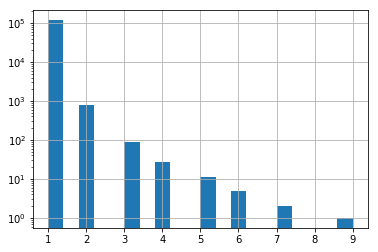

In [21]:
df['title'].value_counts().hist(bins=20, log=True)

Most wines appear only once, but seems like a few appears multiple times

In [22]:
df.groupby(by='country')['designation'].value_counts().nlargest(20)

country    designation    
US         Reserve            1388
           Estate             1119
Italy      Riserva             639
US         Estate Grown        549
Chile      Reserva             492
France     Barrel sample       367
Spain      Crianza             312
US         Dry                 300
France     Vieilles Vignes     279
           Barrel Sample       251
Spain      Reserva             249
US         Estate Bottled      233
Portugal   Reserva             212
Argentina  Reserva             207
France     Tradition           197
Italy      Brut                171
US         Old Vine            171
Italy      Extra Dry           166
US         Rosé of             158
France     Brut Rosé           150
Name: designation, dtype: int64

The designation doesn't seem to be anything regulated

In [23]:
df['country_varietal'] = df['country']+ ' ' +df['varietal']

In [24]:
top_grape = df['varietal'].value_counts().nlargest(50).to_frame('count').reset_index()
top_grape.rename(columns={'index':'varietal'}, inplace=True)
top_grape

,varietal,count
0,Pinot Noir,12278
1,Chardonnay,10868
2,Cabernet Sauvignon,8840
3,Red Blend,8243
4,Bordeaux-style Red Blend,6471
5,Sauvignon Blanc,4857
6,Riesling,4773
7,Shiraz,4618
8,Rosé,3220
9,Merlot,2896


In [25]:
top_grape_country = df['country_varietal'].value_counts().nlargest(75).to_frame('count').reset_index()
top_grape_country.rename(columns={'index':'country_varietal'}, inplace=True)

In [26]:
country_df = df.groupby(by='country').agg({'points':'median','price':'median','description':'; '.join}).reset_index()
varietal_df = df.groupby(by='varietal').agg({'points':'median','price':'median','description':'; '.join}).reset_index()
country_varietal_df = df.groupby(by=['country','varietal']).agg({'points':'median','price':'median','description':'; '.join}).reset_index()
country_varietal_df.head()

,country,varietal,points,price,description
0,Argentina,Barbera,85.0,18.0,"This smells roasted, leathery and earthy, with..."
1,Argentina,Bonarda,87.0,15.0,"Meaty and rubbery, but that's young Bonarda. T..."
2,Argentina,Bordeaux-style Red Blend,91.0,37.0,"Flat in color, with a dull luster, this smells..."
3,Argentina,Bordeaux-style White Blend,83.0,14.0,"Bland and chunky, with aromas of talcum powder..."
4,Argentina,Cabernet Blend,88.0,30.0,This blend of 88% Cabernet Sauvignon and 12% C...


In [27]:
# obtain grape name tokens for later removal from description
grape_names = df['varietal'].fillna('').unique().tolist()
grape_tokens = []
for name in grape_names:
    name = name.lower()
    tokens = re.split('[- ]', name)
    grape_tokens += tokens

In [28]:
wine_remove_words = ['wine','rosé', 'red', 'white', 'drink', 'aroma', 'flavor','vineyard']
other_remove_words = ['\'s', "'"]

In [29]:
post_lem_remove = set(wine_remove_words + other_remove_words)
pre_lem_remove = set([p for p in string.punctuation] + nltk.corpus.stopwords.words('english') + grape_tokens)
#use set to improve performance

def clean_tokenizer(text):
    """Turn long text into lowercase tokens, remove punctuations & stopwords
    e.g: fro"""
    tokens = nltk.tokenize.word_tokenize(text.lower())
    lemmatizer = WordNetLemmatizer()
    
    clean_tokens = [lemmatizer.lemmatize(t) for t in tokens if not 
                    ((t in pre_lem_remove) or (lemmatizer.lemmatize(t) in post_lem_remove) or (t.isnumeric()))]
    
    return clean_tokens

tfidf = TfidfVectorizer(lowercase=False, tokenizer=clean_tokenizer, token_pattern=None,
                        stop_words=None, max_df=0.7, min_df=10, ngram_range=(1,3))
# discarding terms that occur > 70% of the time & < 10 times. Using both normal & bigrams
tfidf_2 = TfidfVectorizer(lowercase=False, tokenizer=clean_tokenizer, token_pattern=None,
                        stop_words=None, max_df=0.7, min_df=10, ngram_range=(1,3))

In [30]:
tfidf_matrix = tfidf.fit_transform(varietal_df['description'])

In [31]:
tfidf_matrix_2 = tfidf_2.fit_transform(country_varietal_df['description'])

In [32]:
tfidf_matrix.shape

(705, 29768)

In [33]:
tfidf_matrix_2.shape

(1592, 34303)

In [34]:
def top_tfidf_feats(tfidf_row, features, n_feats=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    top_ids = np.argsort(tfidf_row)[::-1][:n_feats]
    # sort features in row (by tfidf score) -> ascending
    # then reverse to get descending, then slice top n
    
    top_features = [(features[i], tfidf_row[i]) for i in top_ids]
    df = pd.DataFrame(top_features) # return as a Dataframe
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(tfidf_matrix, features, row_id, n_feats=25):
    ''' Top tfidf features in specific document (matrix row)
    Gotta call this instead of top_tf_idf_feats because tfidf
    is sparse matrix -> does not support all matrix operations.
    '''
    # first convert a row to full matrix format
    row = np.squeeze(tfidf_matrix[row_id].toarray())
    
    # return a df
    return top_tfidf_feats(row, features, n_feats)

In [35]:
features = tfidf.get_feature_names()
features_2 = tfidf_2.get_feature_names()

def look_at(varietal_name, n_feats=10):
    row = varietal_df[varietal_df['varietal']==varietal_name]
    row_id = row.index
    print(top_feats_in_doc(tfidf_matrix, features,row_id, n_feats=n_feats))

def look_at_random(n=10, n_feats=10):
    '''Look at n random wines'''
    row_ids = random.sample(range(1, 100), n)
    for row_id in row_ids:
        print('_'*10)
        print(varietal_df.iloc[row_id]['varietal'])
        print(top_feats_in_doc(tfidf_matrix, features,row_id, n_feats=n_feats))
        
def look_at_cv(country_varietal_name, n_feats=10):
    row = country_varietal_df[country_varietal_df['country_varietal']==country_varietal_name]
    row_id = row.index
    print(top_feats_in_doc(tfidf_matrix_2, features_2,row_id, n_feats=n_feats))

def look_at_random_cv(n=10, n_feats=10):
    '''Look at n random wines'''
    row_ids = random.sample(range(1, 100), n)
    for row_id in row_ids:
        print('_'*10)
        print(country_varietal_df.iloc[row_id]['country_varietal'])
        print(top_feats_in_doc(tfidf_matrix_2, features_2,row_id, n_feats=n_feats))

In [36]:
# the next 2 lines are a repeat of a previous cell
top_grape = df['varietal'].value_counts().nlargest(57).to_frame('count').reset_index()
top_grape.rename(columns={'index':'varietal'}, inplace=True)

top_grape_names = top_grape['varietal'].tolist()
top_grape_names = [grape for grape in top_grape_names if grape not in 
                   ["Red Blend","White Blend","Sparkling Blend","Portuguese Red","Portuguese White", "Port", "Rosé"]]
print(len(top_grape_names))
for grape in top_grape_names[:10]:
    print('_________________')
    print(grape)
    look_at(grape, n_feats=10)

50
_________________
Pinot Noir
      feature     tfidf
0      cherry  0.416591
1   raspberry  0.216906
2      tannin  0.206269
3        cola  0.164828
4     acidity  0.155456
5         oak  0.139267
6   cranberry  0.127962
7  strawberry  0.117904
8       spice  0.112393
9        ripe  0.111617
_________________
Chardonnay
     feature     tfidf
0    acidity  0.236186
1        oak  0.213559
2       pear  0.212767
3  pineapple  0.185041
4      lemon  0.173728
5       ripe  0.166243
6      peach  0.154875
7      toast  0.152705
8       rich  0.144073
9      crisp  0.140029
_________________
Cabernet Sauvignon
      feature     tfidf
0      tannin  0.303268
1  blackberry  0.287101
2      cherry  0.266160
3         oak  0.208596
4     currant  0.193448
5         cab  0.183087
6      cassis  0.182620
7   chocolate  0.139473
8        plum  0.115001
9       cedar  0.112650
_________________
Bordeaux-style Red Blend
      feature     tfidf
0      tannin  0.423229
1        ripe  0.190984
2     

In [37]:
look_at_random(n=10, n_feats=10)

__________
Caprettone
                     feature     tfidf
0           mineral accented  0.219233
1                  zest pear  0.215537
2  palate delivers nectarine  0.215537
3               grape savory  0.215537
4         delivers nectarine  0.212138
5                 flower nut  0.212138
6    acidity give refreshing  0.206060
7                 herb crisp  0.203319
8           fragrance flower  0.200744
9            give refreshing  0.193841
__________
Blauburger
                 feature     tfidf
0              cranberry  0.376179
1         cranberry tart  0.311916
2  cranberry pomegranate  0.304575
3              hungarian  0.286464
4           garnet color  0.281385
5                 garnet  0.258832
6       cherry cranberry  0.252227
7           sweet cherry  0.243414
8            tart finish  0.236875
9           forest floor  0.230925
__________
Brachetto
        feature     tfidf
0     raspberry  0.311138
1         sweet  0.229497
2    strawberry  0.196974
3          ruby  

In [38]:
top_id = varietal_df[varietal_df['varietal'].isin(top_grape_names)].index

In [43]:
country_varietal_df['country_varietal'] = country_varietal_df['country'] + ' ' + country_varietal_df['varietal']
top_cv_names = top_grape_country['country_varietal'].tolist()

In [55]:
print(len(top_cv_names))
for cv in top_cv_names[:10]:
    print('_________________')
    print(cv)
    look_at_cv(cv, n_feats=10)

75
_________________
US Pinot Noir
      feature     tfidf
0      cherry  0.398882
1   raspberry  0.228446
2       fruit  0.205777
3        cola  0.189910
4         oak  0.145866
5   cranberry  0.145163
6      tannin  0.138076
7     acidity  0.123776
8        show  0.114481
9  strawberry  0.112584
_________________
US Cabernet Sauvignon
      feature     tfidf
0      tannin  0.298556
1  blackberry  0.295478
2      cherry  0.249072
3         oak  0.214519
4     currant  0.212702
5       fruit  0.170663
6         cab  0.161280
7   chocolate  0.133238
8      cassis  0.127624
9       cedar  0.123643
_________________
US Chardonnay
          feature     tfidf
0             oak  0.253298
1            pear  0.225448
2       pineapple  0.213367
3        buttered  0.199631
4           lemon  0.192099
5         acidity  0.185633
6  buttered toast  0.176813
7           fruit  0.169804
8         vanilla  0.146367
9           toast  0.145545
_________________
France Bordeaux-style Red Blend
     fe

In [44]:
top_id_2 = country_varietal_df[country_varietal_df['country_varietal'].isin(top_cv_names)].index

In [45]:
len(df.groupby(by='varietal'))

705

In [46]:
len(df[df['varietal'].isin(top_grape_names)])/len(df)

0.7424825815914925

Picking out the top 50 most common grapes combination out of 707 possible values still leaves us with 74% of the bottles.

In [47]:
top_varietal_labels = varietal_df.iloc[top_id]['varietal'].values

In [48]:
top_cv_labels = country_varietal_df.iloc[top_id_2]['country_varietal'].values

In [49]:
top_tfidf_matrix = tfidf_matrix[top_id]

In [50]:
top_tfidf_matrix_2 = tfidf_matrix_2[top_id_2]

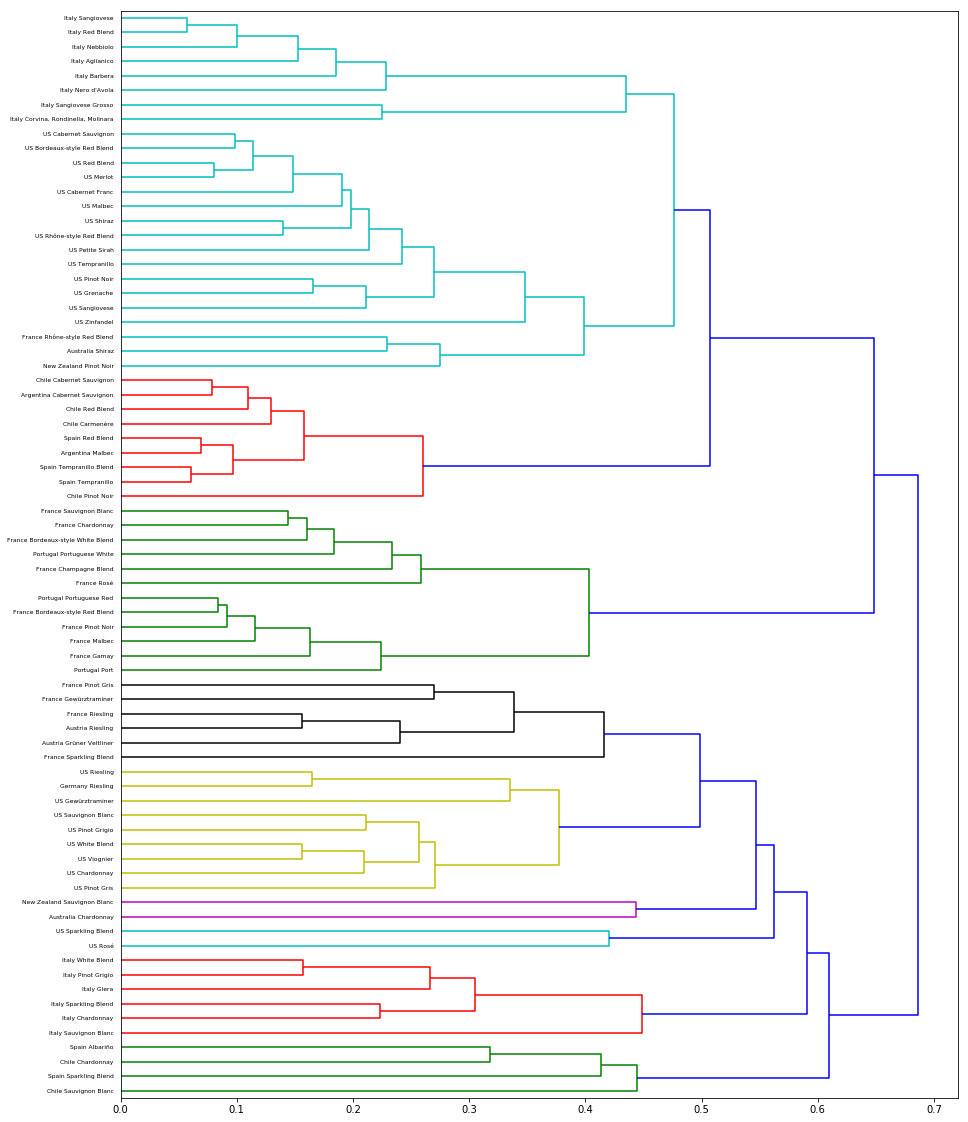

In [51]:
linkage_matrix2 = linkage(top_tfidf_matrix_2.todense(), method='average', metric='cosine')
fig2, ax2 = plt.subplots(figsize=(15, 20)) # set size
ax2 = dendrogram(linkage_matrix2, orientation="right",
                labels=top_cv_labels)

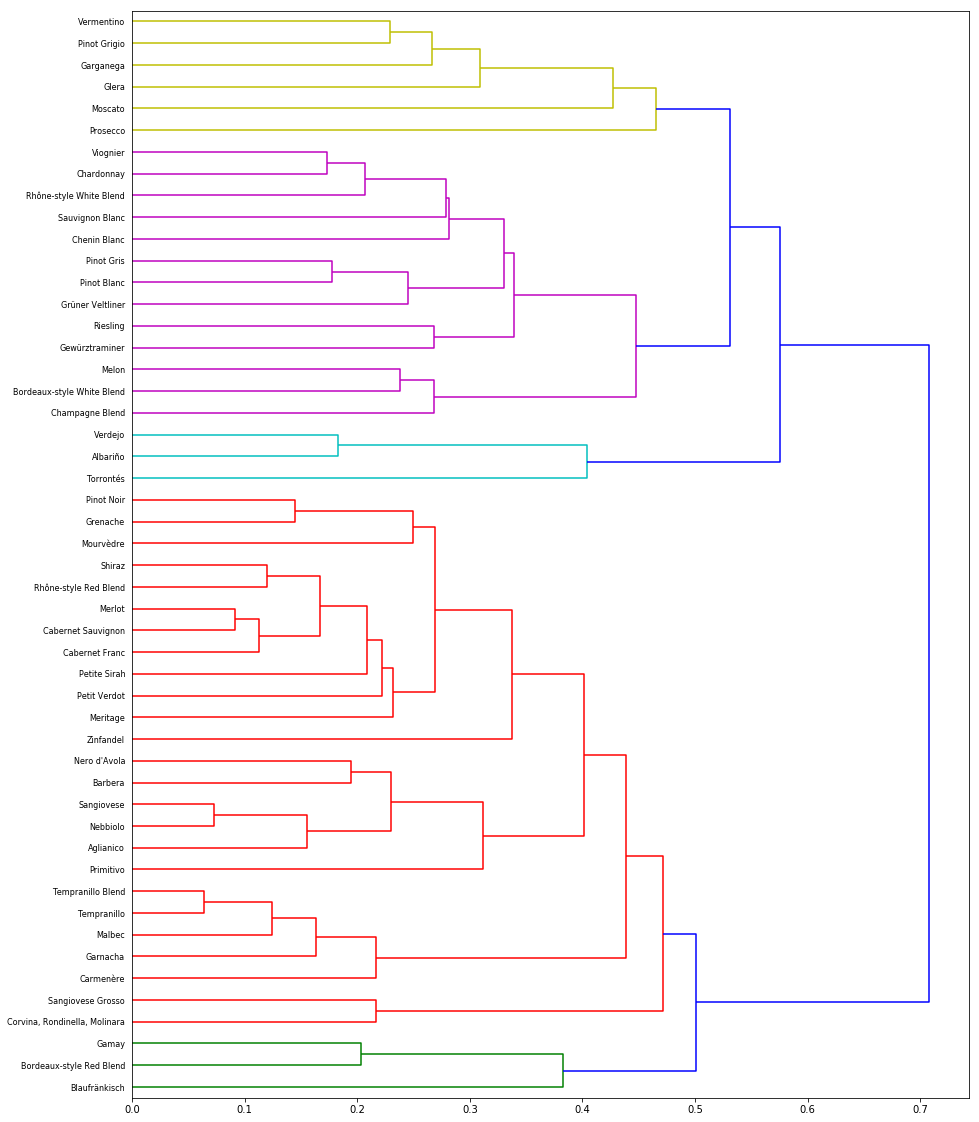

In [52]:
linkage_matrix = linkage(top_tfidf_matrix.todense(), method='average', metric='cosine')
fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right",
                labels=top_varietal_labels)

In [53]:
def top_matching_tfidf_features(grape_list,n):
    """Given arbitrary list of grapes, return top n
    (by tfidf score) of features that matches """
    pass